In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
%matplotlib inline

## Imágenes desde ficheros

ref https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### descargamos imágenes de dos queries en google

In [2]:
!pip install google_images_download

    100% |████████████████████████████████| 911kB 37.5MB/s ta 0:00:01   35% |███████████▎                    | 317kB 932kB/s eta 0:00:01
  Stored in directory: /home/user/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [3]:
downloads = "/tmp/downloads"
traintest_imgs = "/tmp/imgs"

train_pct = .7

In [4]:
!rm -rf $downloads
!mkdir $downloads

In [5]:
cfg="""
{
    "Records": [
        {
            "keywords": "car",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium",
            "output_directory": "%s"
        },
        {
            "keywords": "truck",
            "format": "jpg",
            "limit": 50,
            "type": "photo",
            "size": "medium", 
            "output_directory": "%s"
        }
    ]
}
"""%(downloads, downloads)

In [6]:
with open(downloads+"/cfg.txt", "w") as f:
    f.write(cfg)

In [7]:
!googleimagesdownload --config_file $downloads/cfg.txt


Item no.: 1 --> Item name = car
Evaluating...
Starting Download...
Completed Image ====> 1.592f4169b74af41b008b5977-750-563.jpg
Completed Image ====> 2.heres-why-the-mclaren-720s-worth-280000-is-a-difficult-car-to-love.jpg
Completed Image ====> 3.mazda-vision-coupe-wins-2018-concept-car-of-the-year-4.jpg
Completed Image ====> 4.Lam1_trans_NvBQzQNjv4BqnAdySV0BR-4fDN_-_p756cVfcy8zLGPV4EhRkjQy7tg.jpg
Completed Image ====> 5.ssc-tuatara.jpg
Completed Image ====> 6.911-road-3629a.jpg
Completed Image ====> 7._100284183_hi044452539.jpg
Completed Image ====> 8.McLaren-Senna-car-price-new-2018-890981.jpg
Completed Image ====> 9.dfb51e2e4be24a07b71cbf021a81d6d3.jpg
Completed Image ====> 10.performance.jpg
Completed Image ====> 11.jaguarf-pace.jpg
Completed Image ====> 12.j1qtl37vkiw9nzefmkmw.jpg
Completed Image ====> 13.front-left-side-47.jpg
URLError on an image...trying next one... Error: HTTP Error 403: Forbidden
Completed Image ====> 14.ms_tw.jpg
Completed Image ====> 15.rolls-royce-ghost.j

### revisamos las imágenes y eliminamos las defectuosas

In [12]:
from skimage import io
files = !find $downloads -type f
for fname in files:
    if fname!=downloads+"/cfg.txt":
        print (".", end=" ")
        try:
            io.imread(fname)
        except:
            print ("\nremoving",fname,"as cannot be read\n")
            !rm '$fname'

. . . . . . . . . . . . . . . . . . . . . 
removing /tmp/downloads/car/4.Lam1_trans_NvBQzQNjv4BqnAdySV0BR-4fDN_-_p756cVfcy8zLGPV4EhRkjQy7tg.jpg as cannot be read

rm: cannot remove '$fname': No such file or directory
. . . . . . . . . . . . . . . 
removing /tmp/downloads/car/23.TVR-1_trans_NvBQzQNjv4Bqx5egiJ9MQyAqq6uO2mksLewgQAgQu-frnJ3S4qwBXxU.jpg as cannot be read

rm: cannot remove '$fname': No such file or directory
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
removing /tmp/downloads/truck/12.2019-ford-ranger%20supercab-frontside_ftrscabxl1901.jpg as cannot be read

rm: cannot remove '$fname': No such file or directory
. . . 

### organizamos las imágenes en train y en test

In [15]:
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
print (classdirs)

['car', 'truck']


In [16]:
!rm -rf $traintest_imgs

In [18]:
for classdir in classdirs:
    print (classdir)
    print ("    splitting files ... ",)
    files = !find $downloads/$classdir -type f
    files = np.r_[files]
    n_train = int(len(files)*train_pct)
    files = np.random.permutation(files)
    files_train = files[:n_train]
    files_test  = files[n_train:]
    !mkdir -p $traintest_imgs/train/$classdir
    !mkdir -p $traintest_imgs/test/$classdir
    print ("copying files")
    for f in files_train:
        !cp $f $traintest_imgs/train/$classdir
    for f in files_test:
        !cp $f $traintest_imgs/test/$classdir

car
    splitting files ... 
copying files
truck
    splitting files ... 
copying files


### sanity check 1

In [19]:
for classdir in classdirs:
    print (classdir)
    files = !find  $traintest_imgs/train/$classdir -type f
    print ("      ",len(files), "train images")
    files = !find  $traintest_imgs/test/$classdir -type f
    print ("      ",len(files), "test images")

car
       35 train images
       15 test images
truck
       35 train images
       15 test images


### sanity check 2

see [ImageGenerator](https://keras.io/preprocessing/image/)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [21]:
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 10
img_size = 32
train_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        interpolation = "bilinear",
        class_mode='binary') 

Found 70 images belonging to 2 classes.


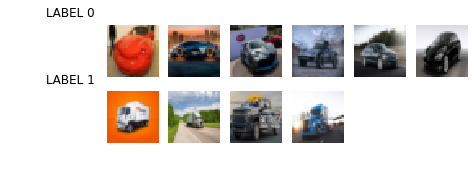

In [26]:
for imgs,labels in train_generator_fn():
    if np.random.random()>.5:
        break
mlutils.show_labeled_image_mosaic(imgs, labels)

### train keras!!!

In [27]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(10,10), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [25]:
num_classes = len(classdirs)
model = get_conv_model_A(num_classes, img_size=img_size)

model.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)


using 2 classes
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Found 70 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Epoch 1/3
7/7 [==============================] - 5s 739ms/step - loss: 1.0396 - acc: 0.4714 - val_loss: 0.6926 - val_acc: 0.4667
Epoch 2/3
7/7 [==============================] - 2s 314ms/step - loss: 0.6925 - acc: 0.5429 - val_loss: 0.6925 - val_acc: 0.5333
Epoch 3/3
7/7 [==============================] - 2s 247ms/step - loss: 0.6857 - acc: 0.7143 - val_loss: 0.6911 - val_acc: 0.5333


### predictions

In [28]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)


Found 30 images belonging to 2 classes.


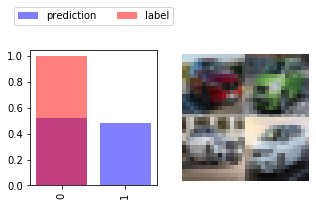

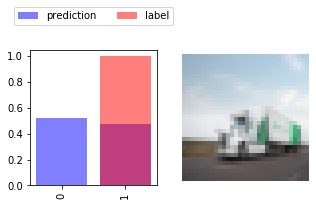

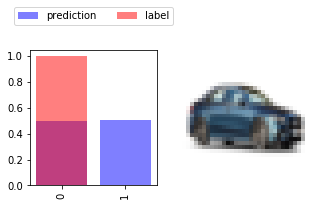

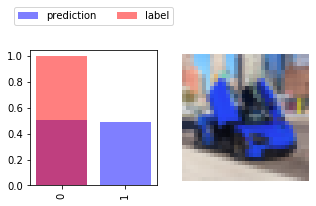

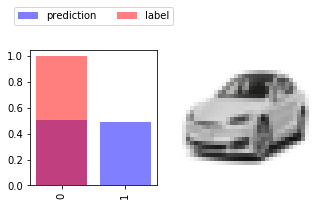

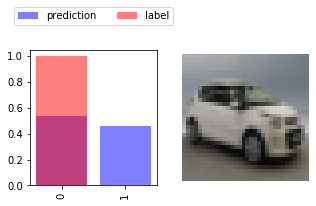

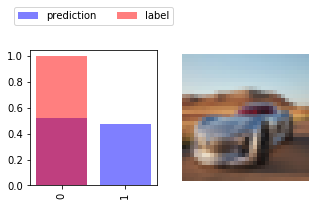

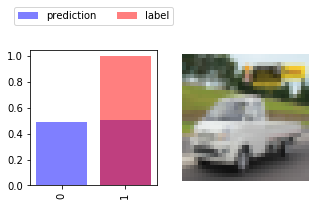

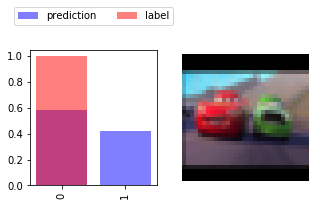

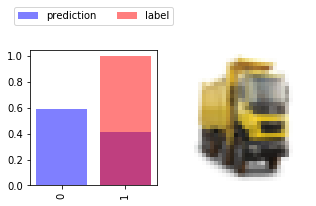

In [29]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
preds = model.predict(x)
mlutils.show_preds(x, y, preds)